# Mount Google Drive, unzip data

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
from pathlib import Path

TRAIN_ZIP_FILE_GDRIVE_PATH = Path("/content/drive/MyDrive/TEyeD_preprocessed/96x96_stride10_q4_train_full.zip")
VAL_ZIP_FILE_GDRIVE_PATH = Path("/content/drive/MyDrive/TEyeD_preprocessed/96x96_stride10_q4_val_full.zip")
UNZIP_DESTINATION = Path("/content/data")

In [ ]:
print("Starting data transfer...")

!unzip -q "{TRAIN_ZIP_FILE_GDRIVE_PATH}" -d "{UNZIP_DESTINATION}"
!unzip -q "{VAL_ZIP_FILE_GDRIVE_PATH}" -d "{UNZIP_DESTINATION}"

print("Data successfully unzipped!")

Starting data transfer...
Data successfully unzipped!


In [14]:
!mv /content/data/96x96_stride10_q4_val_full/val /content/data/96x96_stride10_q4_train_full
!rm -rf /content/data/96x96_stride10_q4_val_full

In [16]:
PREPROCESSED_ROOT = UNZIP_DESTINATION / TRAIN_ZIP_FILE_GDRIVE_PATH.stem

train_root = PREPROCESSED_ROOT / "train"
val_root   = PREPROCESSED_ROOT / "val"
train_csv  = train_root / "labels.csv"
val_csv    = val_root / "labels.csv"

print("Train root", train_root)
print("Validation root", val_root)

Train root /content/data/96x96_stride10_q4_train_full/train
Validation root /content/data/96x96_stride10_q4_train_full/val


# Build datasets

In [17]:
import pandas as pd

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)

print(f"Training rows: {len(train_df)}")

Training rows: 400131


In [18]:
import numpy as np
import pandas as pd

def add_sample_weights(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe = dataframe.copy()

    targets = dataframe[["x", "y"]].to_numpy(np.float32)
    radius = np.linalg.norm(targets, axis=1)

    offcenter_weight_multiplier = 2.0
    radius_weights = np.where(radius >= 0.30, offcenter_weight_multiplier, 1.0).astype(np.float32)

    video_stems = dataframe["filename"].str.split("/", n=1).str[0]
    frames_per_video = video_stems.value_counts()
    video_weights = video_stems.map(lambda stem: 1.0 / frames_per_video[stem]).to_numpy(np.float32)

    sample_weights = radius_weights * video_weights
    sample_weights *= len(sample_weights) / sample_weights.sum()

    dataframe["sample_weight"] = sample_weights
    return dataframe

train_df_weighted = add_sample_weights(train_df)

In [19]:
import tensorflow as tf
import numpy as np
from pathlib import Path

BATCH_SIZE = 128

def augment_image_photometric(image: tf.Tensor) -> tf.Tensor:
    image = tf.clip_by_value(image, 0.0, 1.0)

    image = tf.image.random_brightness(image, max_delta=0.15)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Clip again because brightness/contrast can go out of bounds
    image = tf.clip_by_value(image, 0.0, 1.0)

    apply_gamma = tf.random.uniform([]) < 0.6
    gamma = tf.random.uniform([], 0.85, 1.2)
    image = tf.cond(apply_gamma, lambda: tf.image.adjust_gamma(image, gamma), lambda: image)

    apply_temperature = tf.random.uniform([]) < 0.6
    delta = tf.random.uniform([], -0.10, 0.10)
    channel_gains = tf.reshape(tf.stack([1.0 - delta, 1.0, 1.0 + delta]), [1, 1, 3])
    image = tf.cond(
        apply_temperature,
        lambda: tf.clip_by_value(image * channel_gains, 0.0, 1.0),
        lambda: image,
    )

    noise_standard_deviation = tf.random.uniform([], 0.0, 0.03)
    noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=noise_standard_deviation)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)

    blurred_3 = tf.nn.avg_pool2d(image[None], ksize=3, strides=1, padding="SAME")[0]
    blurred_5 = tf.nn.avg_pool2d(image[None], ksize=5, strides=1, padding="SAME")[0]

    apply_blur = tf.random.uniform([]) < 0.25
    use_large_blur = tf.random.uniform([]) < 0.5
    blurred = tf.cond(use_large_blur, lambda: blurred_5, lambda: blurred_3)
    image = tf.cond(apply_blur, lambda: blurred, lambda: image)

    apply_sharpen = tf.random.uniform([]) < 0.25
    sharpen_amount = tf.random.uniform([], 0.2, 0.45)
    sharpened = tf.clip_by_value(image + sharpen_amount * (image - blurred_3), 0.0, 1.0)
    image = tf.cond(apply_sharpen, lambda: sharpened, lambda: image)

    return image


def random_jpeg_recompression(image: tf.Tensor) -> tf.Tensor:
    image = tf.clip_by_value(image, 0.0, 1.0)
    image_uint8 = tf.cast(tf.round(image * 255.0), tf.uint8)

    quality_options = [35, 45, 55, 65, 75, 85, 95]
    index = tf.random.uniform([], 0, len(quality_options), dtype=tf.int32)

    encoded = tf.switch_case(
        index,
        branch_fns=[lambda q=q: tf.image.encode_jpeg(image_uint8, quality=q) for q in quality_options],
    )

    decoded = tf.image.decode_jpeg(encoded, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    decoded.set_shape((96, 96, 3))
    return decoded


def maybe_flip_left_right(image: tf.Tensor, label: tf.Tensor, sample_weight: tf.Tensor):
    do_flip = tf.random.uniform([]) < 0.5
    image = tf.cond(do_flip, lambda: tf.image.flip_left_right(image), lambda: image)
    x, y = label[0], label[1]
    x = tf.cond(do_flip, lambda: -x, lambda: x)
    label = tf.stack([x, y])
    return image, label, sample_weight

def build_train_loader_weighted(dataframe, root_dir: Path, batch_size: int) -> tf.data.Dataset:
    filepaths = dataframe["filename"].map(lambda name: str(root_dir / name)).to_list()
    targets = dataframe[["x", "y"]].astype("float32").to_numpy()
    sample_weights = dataframe["sample_weight"].astype("float32").to_numpy()

    dataset = tf.data.Dataset.from_tensor_slices((filepaths, targets, sample_weights))
    dataset = dataset.shuffle(50000, seed=42, reshuffle_each_iteration=True)

    def load_image(filepath, target, sample_weight):
        image_bytes = tf.io.read_file(filepath)
        image = tf.image.decode_jpeg(image_bytes, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image.set_shape((96, 96, 3))
        return image, target, sample_weight

    def augment_and_normalize(image, target, sample_weight):
        image = random_jpeg_recompression(image)
        image = augment_image_photometric(image)
        image, target, sample_weight = maybe_flip_left_right(image, target, sample_weight)
        image = (image - 0.5) * 2.0
        return image, target, sample_weight

    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(augment_and_normalize, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = build_train_loader_weighted(train_df_weighted, train_root, BATCH_SIZE)

def build_eval_loader(dataframe, root_dir, batch_size):
    paths = dataframe["filename"].map(lambda f: str(root_dir / f)).to_list()
    targs = dataframe[["x", "y"]].astype("float32").to_numpy()
    ds = tf.data.Dataset.from_tensor_slices((paths, targs))

    def load_norm(p, l):
        img = tf.io.read_file(p)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return (img - 0.5) * 2.0, l

    return ds.map(load_norm).batch(batch_size).cache()

val_ds = build_eval_loader(val_df, val_root, BATCH_SIZE)

In [20]:
import numpy as np
from tensorflow import keras

def with_radius(dataframe):
    dataframe = dataframe.copy()
    xy = dataframe[["x", "y"]].to_numpy(np.float32)
    dataframe["radius"] = np.linalg.norm(xy, axis=1)
    return dataframe

v_rad = with_radius(val_df)
val_off_df = v_rad[v_rad["radius"] >= 0.30]
val_offcenter_ds = build_eval_loader(val_off_df, val_root, BATCH_SIZE)

class OffcenterValidation(keras.callbacks.Callback):
    def __init__(self, offcenter_dataset):
        super().__init__()
        self.offcenter_dataset = offcenter_dataset

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Calculate MAE specifically on the off-center subset
        results = self.model.evaluate(self.offcenter_dataset, verbose=0, return_dict=True)
        logs["val_mae_offcenter"] = float(results["mae"])
        print(f" — val_mae_offcenter: {logs['val_mae_offcenter']:.4f}", end="")

# Model training

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(96, 96, 3))

base = keras.applications.MobileNetV3Small(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    include_preprocessing=False,
    alpha=0.75,
)

x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(2, activation="tanh")(x)

model = keras.Model(inputs, outputs)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


2910456/2910456 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 3, 3, 432)      │       583,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 432)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 432)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 638,842 (2.44 MB)

 Trainable params: 629,162 (2.40 MB)

 Non-trainable params: 9,680 (37.81 KB)

In [22]:
base.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.Huber(delta=0.1),
    metrics=["mae"]
)

offcenter_validation = OffcenterValidation(val_offcenter_ds)

print("Phase 1: fine tuning only the head...")

model.fit(train_ds, validation_data=val_ds, epochs=6, callbacks=[offcenter_validation])

Phase 1: fine tuning only the head...
Epoch 1/6
3127/3127 ━━━━━━━━━━━━━━━━━━━━ 193s 56ms/step - loss: 0.0113 - mae: 0.1565 - val_loss: 0.0035 - val_mae: 0.0682 - val_mae_offcenter: 0.1989
Epoch 2/6
3127/3127 ━━━━━━━━━━━━━━━━━━━━ 130s 42ms/step - loss: 0.0037 - mae: 0.0577 - val_loss: 0.0038 - val_mae: 0.0709 - val_mae_offcenter: 0.1976
Epoch 3/6
3127/3127 ━━━━━━━━━━━━━━━━━━━━ 132s 42ms/step - loss: 0.0037 - mae: 0.0570 - val_loss: 0.0035 - val_mae: 0.0669 - val_mae_offcenter: 0.1980
Epoch 4/6
3127/3127 ━━━━━━━━━━━━━━━━━━━━ 131s 42ms/step - loss: 0.0036 - mae: 0.0565 - val_loss: 0.0035 - val_mae: 0.0660 - val_mae_offcenter: 0.1976
Epoch 5/6
3127/3127 ━━━━━━━━━━━━━━━━━━━━ 131s 42ms/step - loss: 0.0036 - mae: 0.0564 - val_loss: 0.0043 - val_mae: 0.0813 - val_mae_offcenter: 0.2115
Epoch 6/6
3127/3127 ━━━━━━━━━━━━━━━━━━━━ 131s 42ms/step - loss: 0.0036 - mae: 0.0568 - val_loss: 0.0035 - val_mae: 0.0664 - val_mae_offcenter: 0.1973


In [23]:
# Full fine tuning

from tensorflow.keras import optimizers

base.trainable = True

for layer in base.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

model.compile(optimizer=optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-3),
              loss=keras.losses.Huber(delta=0.1),
              metrics=["mae"])

checkpoint_best_offcenter = keras.callbacks.ModelCheckpoint(
    filepath="best_offcenter.keras",
    monitor="val_mae_offcenter",
    mode="min",
    save_best_only=True,
    verbose=1,
)

checkpoint_best_overall = keras.callbacks.ModelCheckpoint(
    filepath="best_overall.keras",
    monitor="val_mae",
    mode="min",
    save_best_only=True,
    verbose=0,
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_mae",
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=6,
    mode="min",
    restore_best_weights=True,
    verbose=1
)

print("Phase 2: full fine tuning...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        offcenter_validation,
        lr_scheduler,
        early_stopping,
        checkpoint_best_offcenter,
        checkpoint_best_overall,
    ]
)

Phase 2: full fine tuning...
Epoch 1/50
3127/3127 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0019 - mae: 0.0427 — val_mae_offcenter: 0.0583
Epoch 1: val_mae_offcenter improved from inf to 0.05832, saving model to best_offcenter.keras
3127/3127 ━━━━━━━━━━━━━━━━━━━━ 196s 52ms/step - loss: 0.0019 - mae: 0.0427 - val_loss: 0.0014 - val_mae: 0.0421 - val_mae_offcenter: 0.0583 - learning_rate: 3.0000e-04
Epoch 2/50
3126/3127 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.4147e-04 - mae: 0.0282 — val_mae_offcenter: 0.0539
Epoch 2: val_mae_offcenter improved from 0.05832 to 0.05387, saving model to best_offcenter.keras
3127/3127 ━━━━━━━━━━━━━━━━━━━━ 134s 43ms/step - loss: 8.4149e-04 - mae: 0.0282 - val_loss: 7.6065e-04 - val_mae: 0.0282 - val_mae_offcenter: 0.0539 - learning_rate: 3.0000e-04
Epoch 3/50
3126/3127 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.2293e-04 - mae: 0.0257 — val_mae_offcenter: 0.0386
Epoch 3: val_mae_offcenter improved from 0.05387 to 0.03859, saving model to best_offcenter

In [27]:
import numpy as np
import os

def compute_binned_mae(true_xy: np.ndarray, predicted_xy: np.ndarray, bin_edges: list[float]):
    true_radius = np.linalg.norm(true_xy, axis=1)
    absolute_error = np.abs(true_xy - predicted_xy)
    sample_mae = absolute_error.mean(axis=1)

    results = []
    for lower_edge, upper_edge in zip(bin_edges[:-1], bin_edges[1:]):
        in_bin = (true_radius >= lower_edge) & (true_radius < upper_edge)
        count = int(in_bin.sum())
        if count == 0:
            results.append((lower_edge, upper_edge, 0, np.nan))
            continue
        results.append((lower_edge, upper_edge, count, float(sample_mae[in_bin].mean())))
    return results

def summarize_bias(true_xy: np.ndarray, predicted_xy: np.ndarray):
    true_radius = np.linalg.norm(true_xy, axis=1)
    predicted_radius = np.linalg.norm(predicted_xy, axis=1)
    mean_error = (predicted_xy - true_xy).mean(axis=0)
    print("Mean (pred - true)  x,y:", mean_error.tolist())
    print("Mean true radius:", float(true_radius.mean()))
    print("Mean pred radius:", float(predicted_radius.mean()))

validation_true = val_df[["x", "y"]].to_numpy(np.float32)
bin_edges = [0.0, 0.10, 0.20, 0.30, 0.40, 0.60, 10.0]

checkpoints_to_test = [
    ("Best overall (val_mae)", "best_overall.keras"),
    ("Best off-center (val_mae_offcenter)", "best_offcenter.keras")
]

for name, filename in checkpoints_to_test:
    print(f"\n\n{'='*60}")
    print(f"EVALUATING CHECKPOINT: {name}")
    print(f"{'='*60}")

    if not os.path.exists(filename):
        print(f"❌ File {filename} not found")
        continue

    try:
        loaded_model = keras.models.load_model(filename)
        print(f"Model loaded: {filename}")

        preds = loaded_model.predict(val_ds, verbose=0).astype(np.float32)

        print("\n--- Bias summary ---")
        summarize_bias(validation_true, preds)

        print("\n--- Binned MAE ---")
        for lower, upper, count, mean_mae in compute_binned_mae(validation_true, preds, bin_edges):
            print(f"radius in [{lower:.2f},{upper:.2f})  n={count:5d}  mae={mean_mae:.5f}")

    except Exception as e:
        print(f"Error evaluating {filename}: {e}")



EVALUATING CHECKPOINT: Best Overall (val_mae)
Model loaded: best_overall.keras

--- Bias summary ---
Mean (pred - true)  x,y: [-0.00044092052849009633, -0.00042058390681631863]
Mean true radius: 0.1883215457201004
Mean pred radius: 0.1867208480834961

--- Binned MAE ---
radius in [0.00,0.10)  n= 4179  mae=0.01910
radius in [0.10,0.20)  n=33697  mae=0.01502
radius in [0.20,0.30)  n=20918  mae=0.01898
radius in [0.30,0.40)  n= 2078  mae=0.03134
radius in [0.40,0.60)  n=  916  mae=0.03409
radius in [0.60,10.00)  n=   35  mae=0.06939


EVALUATING CHECKPOINT: Best Off-Center (val_mae_offcenter)
Model loaded: best_offcenter.keras

--- Bias summary ---
Mean (pred - true)  x,y: [-4.092985079751088e-07, -0.0022311313077807426]
Mean true radius: 0.1883215457201004
Mean pred radius: 0.19002027809619904

--- Binned MAE ---
radius in [0.00,0.10)  n= 4179  mae=0.01967
radius in [0.10,0.20)  n=33697  mae=0.01572
radius in [0.20,0.30)  n=20918  mae=0.01936
radius in [0.30,0.40)  n= 2078  mae=0.03132

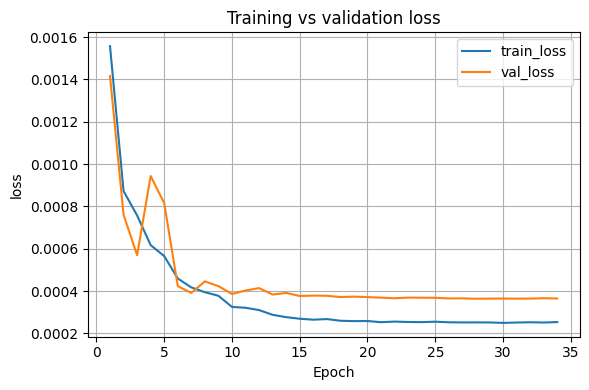

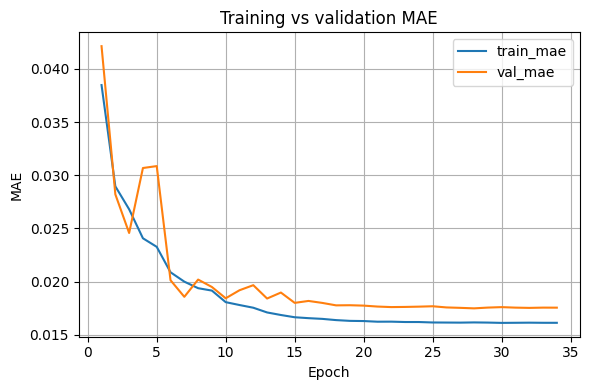

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
epochs = history_df.index + 1

plt.figure(figsize=(6, 4))
plt.plot(epochs, history_df["loss"], label="train_loss")
plt.plot(epochs, history_df["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.title("Training vs validation loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if "mae" in history_df.columns and "val_mae" in history_df.columns:
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history_df["mae"], label="train_mae")
    plt.plot(epochs, history_df["val_mae"], label="val_mae")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.title("Training vs validation MAE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step
Visualizing with MAE per sample...


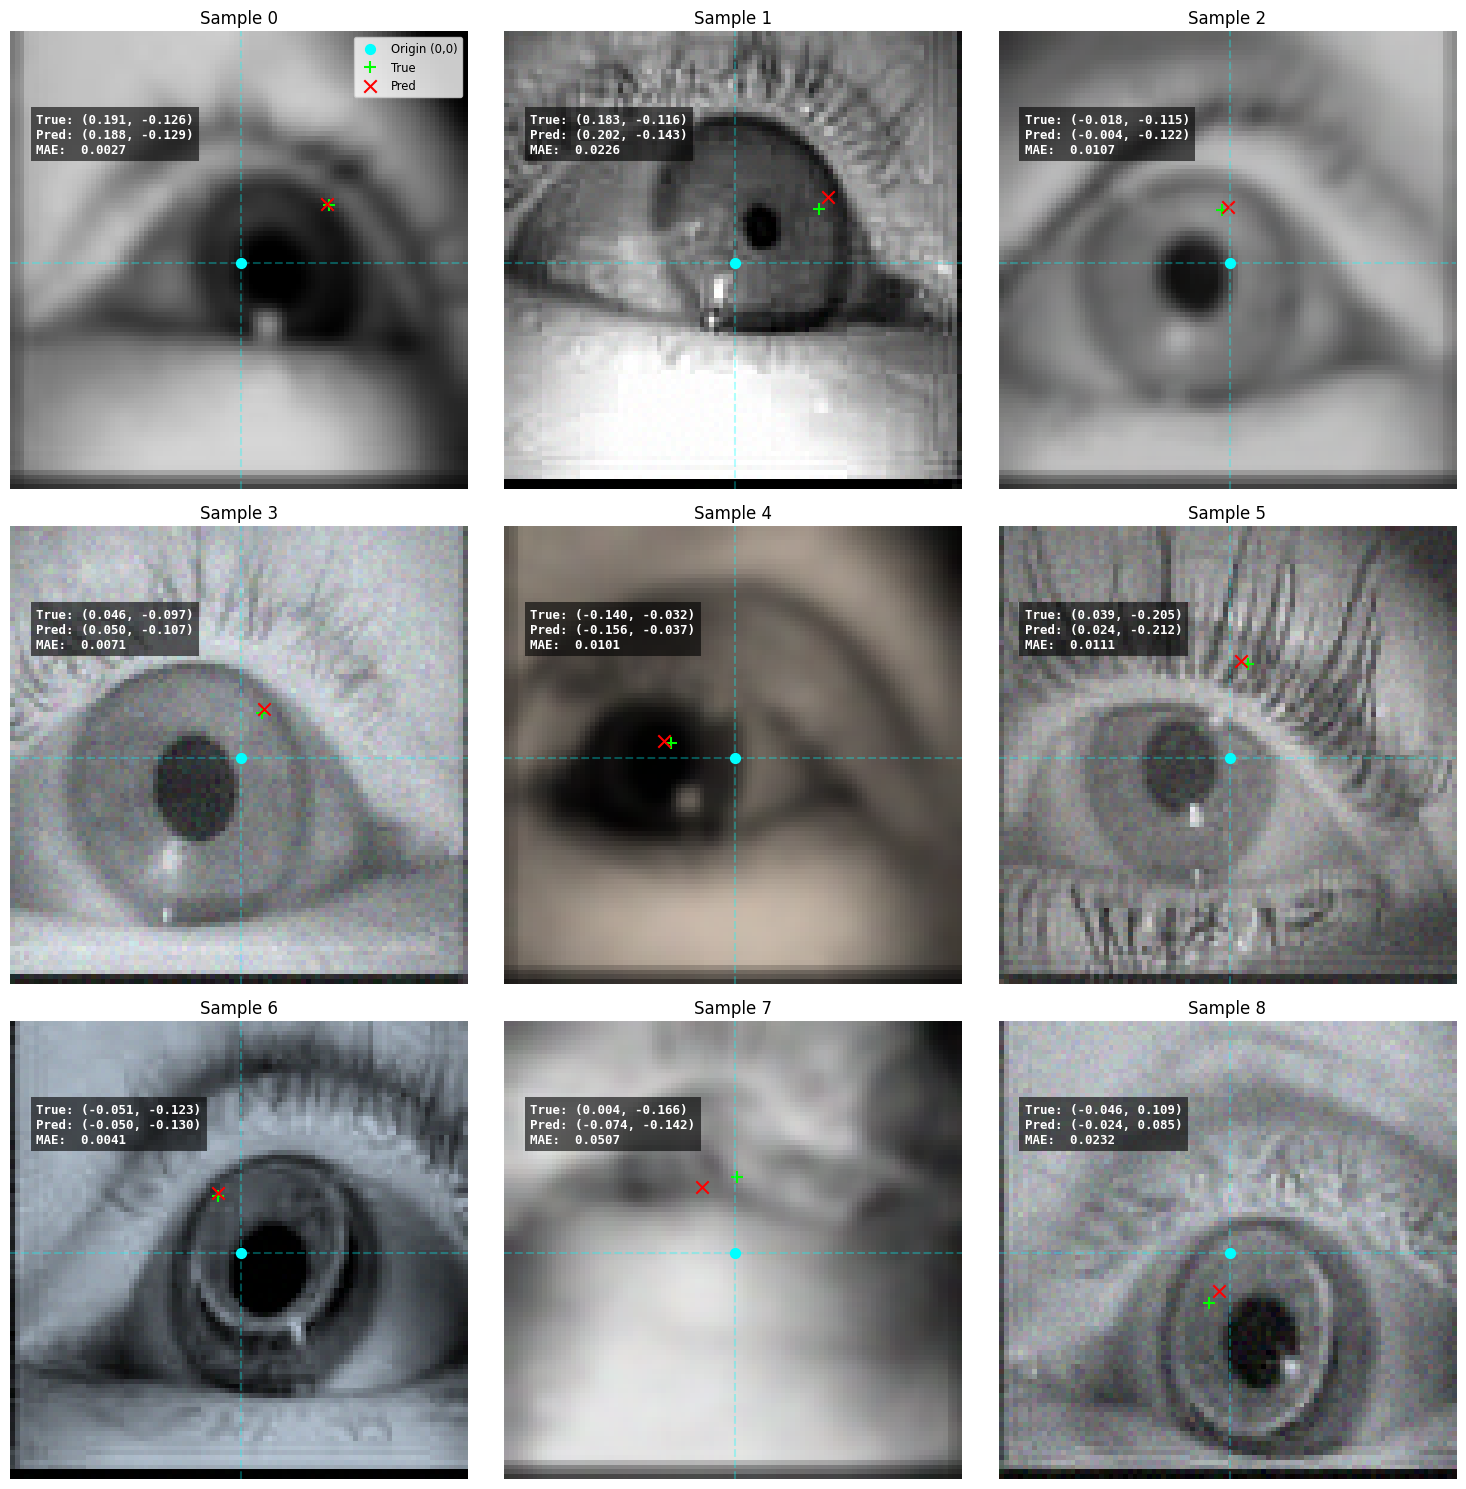

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Grab a batch
train_images, train_labels, _ = next(iter(train_ds))

# 2. Predict
train_preds = model.predict(train_images)

# 3. Visualization with MAE and Origin
def plot_centered_data_with_mae(images, true_labels, pred_labels, count=9):
    plt.figure(figsize=(15, 15))

    IMG_SIZE = 96
    CENTER_PIXEL = IMG_SIZE / 2.0  # 48.0

    for i in range(min(count, len(images))):
        plt.subplot(3, 3, i + 1)

        # Denormalize Image
        img_display = (images[i] / 2.0) + 0.5
        img_display = np.clip(img_display, 0.0, 1.0)
        plt.imshow(img_display, cmap='gray')

        # --- DRAW ORIGIN (0,0) ---
        plt.axhline(y=CENTER_PIXEL, color='cyan', linestyle='--', alpha=0.3)
        plt.axvline(x=CENTER_PIXEL, color='cyan', linestyle='--', alpha=0.3)
        plt.scatter([CENTER_PIXEL], [CENTER_PIXEL], c='cyan', s=50, marker='o', label='Origin (0,0)')

        t_x, t_y = true_labels[i]
        p_x, p_y = pred_labels[i]

        # --- CALCULATE MAE ---
        # Average L1 distance for this single sample
        sample_mae = np.mean(np.abs(true_labels[i] - pred_labels[i]))

        # --- COORDINATE MAPPING ---
        true_px_x = (t_x + 0.5) * IMG_SIZE
        true_px_y = (t_y + 0.5) * IMG_SIZE
        pred_px_x = (p_x + 0.5) * IMG_SIZE
        pred_px_y = (p_y + 0.5) * IMG_SIZE

        # Plot Points
        plt.scatter([true_px_x], [true_px_y], c='lime', s=80, marker='+', label='True')
        plt.scatter([pred_px_x], [pred_px_y], c='red', s=80, marker='x', label='Pred')

        # Text Labels (Coords + MAE)
        text_str = (
            f"True: ({t_x:.3f}, {t_y:.3f})\n"
            f"Pred: ({p_x:.3f}, {p_y:.3f})\n"
            f"MAE:  {sample_mae:.4f}"
        )

        plt.text(5, 25, text_str, color="white", fontsize=9,
                 fontweight='bold', fontfamily='monospace',
                 bbox=dict(facecolor='black', alpha=0.6, edgecolor='none'))

        plt.title(f"Sample {i}")
        plt.axis("off")

        if i == 0:
            plt.legend(loc='upper right', fontsize='small')

    plt.tight_layout()
    plt.show()

print("Visualizing with MAE per sample...")
plot_centered_data_with_mae(train_images, train_labels, train_preds)

# Save the model

In [ ]:
model.save("eye_tracking_model.keras")
print("Model saved")

Model saved
